# Most Unstable Parcel

**GOAL:** Calculate the most unstable parcel in a given layer

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.io import get_upper_air_data
from metpy.plots import SkewT
from metpy.units import units
import numpy as np
from metpy.constants import kappa
%matplotlib inline

In [2]:
# Download and parse the data
dataset = get_upper_air_data(datetime(1999, 5, 4, 0), 'OUN', retry_delay=1000)

p = dataset.variables['pressure'][:]
T = dataset.variables['temperature'][:]
Td = dataset.variables['dewpoint'][:]
u = dataset.variables['u_wind'][:]
v = dataset.variables['v_wind'][:]

In [22]:
def get_layer(p, datavar, bottom=None, depth=100*units.hPa, interpolate=True):
    
    # Make sure pressure and datavar are the same length
    if len(p) != len(datavar):
        raise ValueError("Pressure and data variable must have the same length.")
                
    # If no bottom is specified, use the first pressure value
    if not bottom:
        bottom_pressure = p[0]

    # If bottom is specified as a height (AGL), convert to pressure
    if bottom:
        if bottom.dimensionality == {'[length]': 1.0}:
            bottom_pressure = mpcalc.pressure_at_height_above_pressure(p[0], bottom)
        if bottom.dimensionality == {'[length]': -1.0, '[mass]': 1.0, '[time]': -2.0}:
            bottom_pressure = bottom

    # Calculate the pressure at the top of the layer
    if depth.dimensionality == {'[length]': 1.0}:
        top_pressure = pressure_at_height_above_pressure(bottom, depth)
    else:
        top_pressure = p[0] - depth

    # Handle top or bottom values that are invalid
    if bottom_pressure > p[0]:
        raise ValueError("Bottom of layer pressure is greater than the largest pressure in data.")
    if top_pressure < p[-1]:
        raise ValueError("Top of layer pressure is less than the lowest pressure in data.")
    if bottom_pressure < top_pressure:
        raise ValueError("Pressure at the top of the layer is greater than that at the bottom.")    
        
    # Mask the pressure values we have data for in the layer
    inds = (p <= bottom_pressure) & (p >= top_pressure)
    p_interp = p[inds]
    
    if interpolate:
        # If we don't have the bottom or top requested, append them
        if top_pressure not in p_interp:
            p_interp = np.sort(np.append(p_interp, top_pressure)) * units.hPa
        if bottom_pressure not in p_interp:
            p_interp = np.sort(np.append(p_interp, bottom_pressure)) * units.hPa

        # Interpolate for the possibly missing bottom/top pressure values
        sort_args = np.argsort(p)
        datavar_interp = np.interp(p_interp, p[sort_args], T[sort_args]) * units.degC
        p = p_interp
        datavar = datavar_interp
    else:
        datavar = datavar[inds]
        p = p_interp
        
    return p, datavar

def most_unstable_parcel(p, T, Td, bottom=None, depth=500*units.hPa):
    
    # Calculate the equivalent potential temperature profile
    theta_e = mpcalc.equivalent_potential_temperature(p, T)

    # Find the maximum theta-e, this is the most unstable parcel.
    ind = np.argmax(theta_e)
    
    return p[ind], T[ind], Td[ind]

In [23]:
print(most_unstable_parcel(p, T, Td, bottom=1000*units.hPa))
mup, muT, muTd = most_unstable_parcel(p, T, Td)

(<Quantity(790.0, 'hectopascal')>, <Quantity(15.6, 'degC')>, <Quantity(-10.4, 'degC')>)


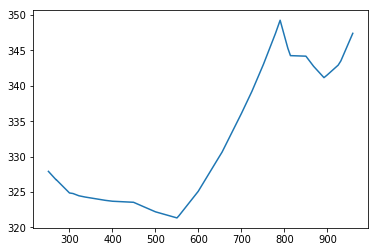

In [24]:
plt.plot(p, mpcalc.equivalent_potential_temperature(p, T))

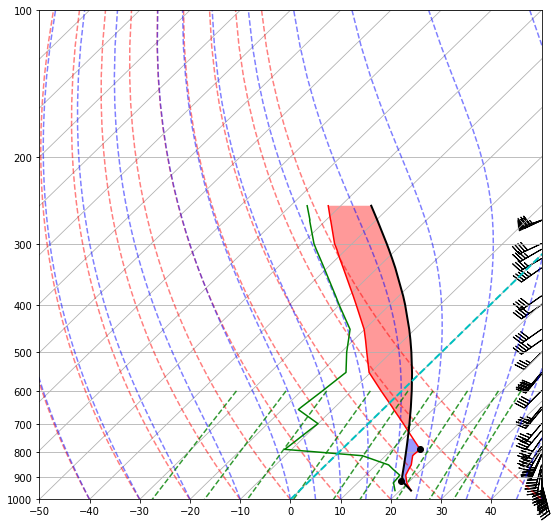

In [13]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

skew.plot(mup, muT, 'ko', markerfacecolor='black')


# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Example of coloring area between profiles
greater = T >= prof
skew.ax.fill_betweenx(p, T, prof, where=greater, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T, prof, where=~greater, facecolor='red', alpha=0.4)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

In [21]:
p.dimensionality

<UnitsContainer({'[length]': -1.0, '[mass]': 1.0, '[time]': -2.0})>

In [26]:
from urllib.request import urlopen

In [27]:
url = 'http://www.google.com'
with urlopen(url) as fobj:
    print(fobj.getcode())

200
